# Test of Python analysis


https://scikit-image.org/docs/dev/auto_examples/filters/plot_nonlocal_means.html
    
Works well for random gaussian noise but not as good for salt and pepper
https://www.iro.umontreal.ca/~mignotte/IFT6150/Articles/Buades-NonLocal.pdf
    
The non-local means algorithm replaces the value of a pixel by an average 
of a selection of other pixels values: small patches centered on the other 
pixels are compared to the patch centered on the pixel of interest, and the 
average is performed only for pixels that have patches close to the current patch. 

In [1]:
import cv2
import numpy as np
from skimage import io, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from matplotlib import pyplot as plt
from tifffile import imread

# 1) Read an image in FLOAT with io.imread or with tifffile.imread

### io.imread

In [2]:
#import our images as float (this is the format that skimage likes)
img_blue = img_as_float(io.imread('247010 vim-g lamp2-r 20x010/nd_cropc1.tif', as_gray=True))
#img_green = img_as_float(io.imread('247010 vim-g lamp2-r 20x010/nd_cropc2.tif', as_gray=True))
#img_red = img_as_float(io.imread('247010 vim-g lamp2-r 20x010/nd_cropc3.tif', as_gray=True))

In [3]:
img_blue.dtype

dtype('float64')

### tifffile.imread

In [4]:
ch1 = imread('247010 vim-g lamp2-r 20x010/nd_cropc1.tif').astype(np.float64)

In [5]:
ch1.dtype

dtype('float64')

# 2) Visualize image

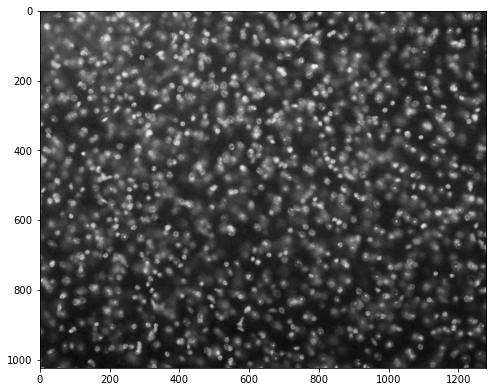

In [6]:
plt.figure(figsize = (8,8))
plt.imshow(img_blue, cmap="gray");

# cannot view the one imported with tifffile.imread

# 3) Denoise Non_local means algorithm


### let's first try to estimate the sigma

In [7]:
sigma_est = np.mean(estimate_sigma(img_blue, multichannel=False))
sigma_est

0.0002863179066878383

### apply Non_local means algorithm

In [8]:
img_blue_denoised = denoise_nl_means(img_blue, h=2 * sigma_est, fast_mode=True,
                               patch_size=3, patch_distance=5, multichannel=False)

When the fast_mode argument is **False**, a spatial Gaussian weighting is applied 
to the patches when computing patch distances. 

When fast_mode is **True** a faster algorithm employing uniform spatial weighting on the patches is applied.


Larger h allows more smoothing between disimilar patches.

### View images side-by-side

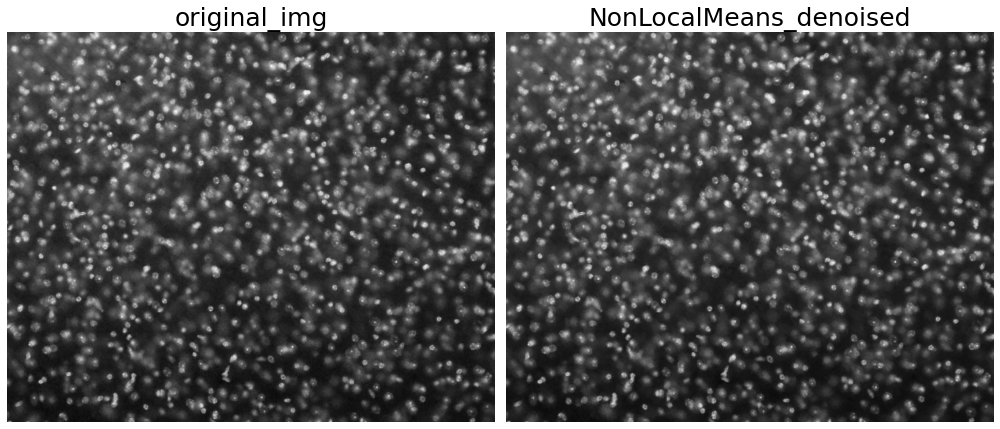

In [9]:
##let's view original vs NonLocalMeans_filtered
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                         figsize=(14, 14))
ax = axes.ravel()
ax[0].imshow(img_blue, cmap=plt.cm.gray)
ax[0].set_title('original_img', fontsize=25)
ax[1].imshow(img_blue_denoised , cmap=plt.cm.gray)
ax[1].set_title('NonLocalMeans_denoised', fontsize=25)
for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show();

### Save image

In [10]:
io.imsave(fname="247010 vim-g lamp2-r 20x010/img_blue_denoised.tif", arr=img_blue_denoised)

#plt.imsave("img_green_denoised.tiff", img_blue_denoised, cmap='gray')

C:\Users\mdp18pm\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 247010 vim-g lamp2-r 20x010/img_blue_denoised.tif is a low contrast image
  """Entry point for launching an IPython kernel.


### I show cropped regions to better check for image improvement

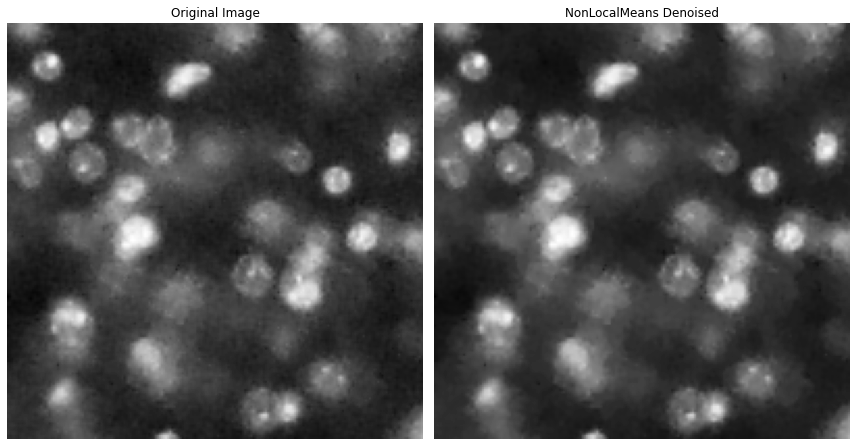

In [25]:
cropped_img_blue3 = img_blue[250:450, 250:450]
cropped_NonLocalMeans = img_blue_denoised[250:450, 250:450]



# plot figures
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12),
                       sharex=True, sharey=True)
plt.gray()
ax[0].imshow(cropped_img_blue3)
ax[0].axis('off')
ax[0].set_title('Original Image')
ax[1].imshow(cropped_NonLocalMeans)
ax[1].axis('off')
ax[1].set_title('NonLocalMeans Denoised')
fig.tight_layout()
plt.show()

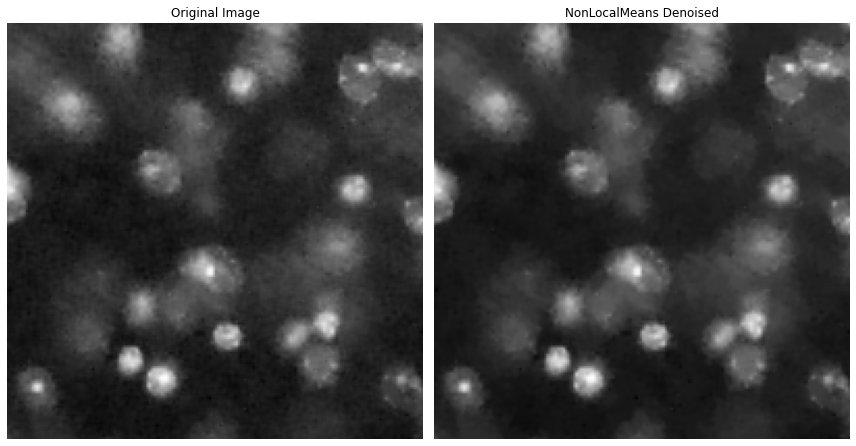

In [12]:
cropped_img_blue3 = img_blue[550:750, 550:750]
cropped_NonLocalMeans = img_blue_denoised[550:750, 550:750]



# plot figures
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12),
                       sharex=True, sharey=True)
plt.gray()
ax[0].imshow(cropped_img_blue3)
ax[0].axis('off')
ax[0].set_title('Original Image')
ax[1].imshow(cropped_NonLocalMeans)
ax[1].axis('off')
ax[1].set_title('NonLocalMeans Denoised')
fig.tight_layout()
plt.show()

### Let's also check whether there are any improvements in the Histograms (showing pixel distribution)

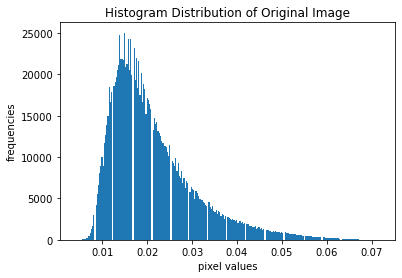

In [13]:
ax = plt.hist(img_blue.ravel(), bins = 256)

# Add title and axis names
plt.title('Histogram Distribution of Original Image')
plt.xlabel('pixel values')
plt.ylabel('frequencies')

plt.show()

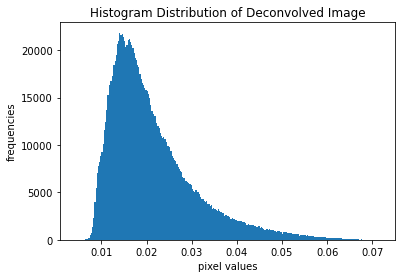

In [14]:
ax = plt.hist(img_blue_denoised.ravel(), bins = 256)

# Add title and axis names
plt.title('Histogram Distribution of Deconvolved Image')
plt.xlabel('pixel values')
plt.ylabel('frequencies')

plt.show()

# ------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------

# ------------------------------------------------------------------------------------------------

# 4) Another method for improving the quality of the image: Image Deconvolution

https://scikit-image.org/docs/dev/auto_examples/filters/plot_restoration.html

In this example, we deconvolve a noisy version of an image using Wiener
and unsupervised Wiener algorithms. This algorithms are based on
linear models that can't restore sharp edge as much as non-linear
methods (like TV restoration) but are much faster.

## Wiener filter
The inverse filter based on the PSF (Point Spread Function),
the prior regularisation (penalisation of high frequency) and the
tradeoff between the data and prior adequacy. The regularization
parameter must be hand tuned.

## Unsupervised Wiener
This algorithm has a self-tuned regularisation parameters based on
data learning. This is not common and based on the following
publication [1]_. The algorithm is based on a iterative Gibbs sampler that
draw alternatively samples of posterior conditional law of the image,
the noise power and the image frequency power.

.. [1] François Orieux, Jean-François Giovannelli, and Thomas
       Rodet, "Bayesian estimation of regularization and point
       spread function parameters for Wiener-Hunt deconvolution",
       J. Opt. Soc. Am. A 27, 1593-1607 (2010)


In [15]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import color, data, restoration

#astro = color.rgb2gray(data.astronaut())
from scipy.signal import convolve2d as conv2
psf = np.ones((3, 3)) / 9   #can also try ((3,3))/9
img_blue_conv = conv2(img_blue, psf, 'same')
img_blue_conv += 0.1 * img_blue_conv.std() * np.random.standard_normal(img_blue_conv.shape)

deconvolved, _ = restoration.unsupervised_wiener(img_blue_conv, psf)

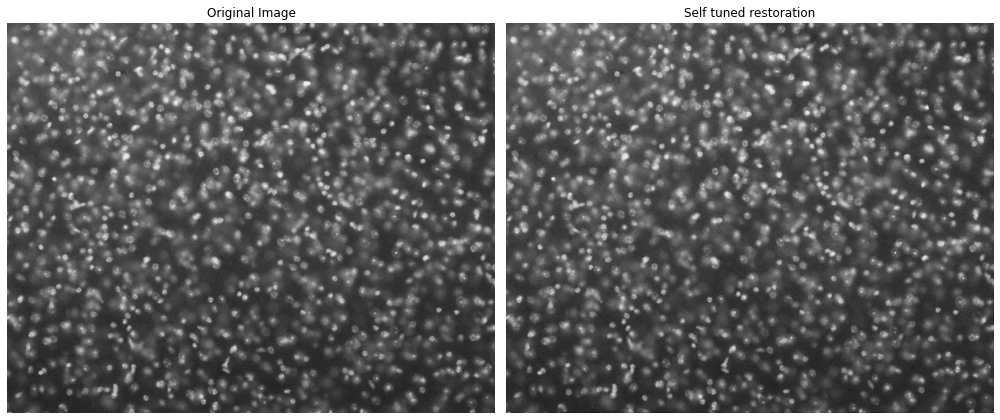

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 14),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(img_blue, vmin=deconvolved.min(), vmax=deconvolved.max())
ax[0].axis('off')
ax[0].set_title('Original Image')

ax[1].imshow(deconvolved)
ax[1].axis('off')
ax[1].set_title('Self tuned restoration')

fig.tight_layout()

plt.show()

In [17]:
deconvolved.dtype

dtype('float64')

### save Deconvolved image

In [18]:
io.imsave(fname="247010 vim-g lamp2-r 20x010/img_blue_deconvolved.tif", arr=deconvolved)


C:\Users\mdp18pm\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: 247010 vim-g lamp2-r 20x010/img_blue_deconvolved.tif is a low contrast image
  """Entry point for launching an IPython kernel.


## Show cropped images for better comparison

In [19]:
img_blue.shape

(1024, 1280)

In [20]:
deconvolved.shape

(1024, 1280)

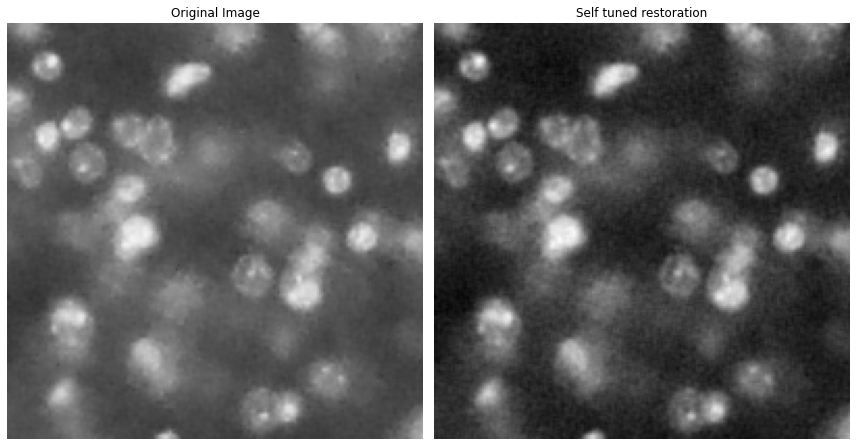

In [21]:
cropped_img_blue = img_blue[250:450, 250:450]
cropped_deconvolved = deconvolved[250:450, 250:450]



# plot figures
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12),
                       sharex=True, sharey=True)
plt.gray()
ax[0].imshow(cropped_img_blue, vmin=deconvolved.min(), vmax=deconvolved.max())
ax[0].axis('off')
ax[0].set_title('Original Image')
ax[1].imshow(cropped_deconvolved)
ax[1].axis('off')
ax[1].set_title('Self tuned restoration')
fig.tight_layout()
plt.show()

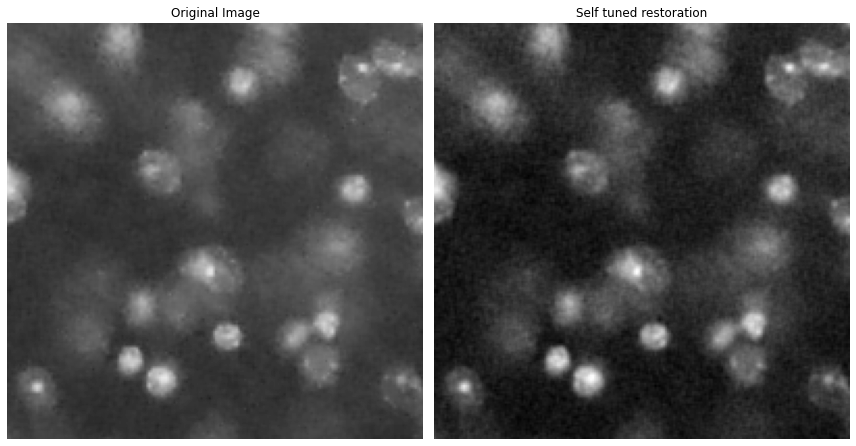

In [22]:
cropped_img_blue2 = img_blue[550:750, 550:750]
cropped_deconvolved2 = deconvolved[550:750, 550:750]



# plot figures
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 12),
                       sharex=True, sharey=True)
plt.gray()
ax[0].imshow(cropped_img_blue2, vmin=deconvolved.min(), vmax=deconvolved.max())
ax[0].axis('off')
ax[0].set_title('Original Image')
ax[1].imshow(cropped_deconvolved2)
ax[1].axis('off')
ax[1].set_title('Self tuned restoration')
fig.tight_layout()
plt.show()

## Comments

The results of the Deconvolution Wiener filter are very promising despite it does not look like that at a first glance. It's much better noticable in the cropped images.

The generated image has an histogram distribution of pixels which is quite impressively improved compared to the original image.

The much better distribution of pixels allows to further manipulate (for example in FIJI as well) the contrast, subtraction of backgroun and sharpening.

### Check histograms to further show the nice improvement

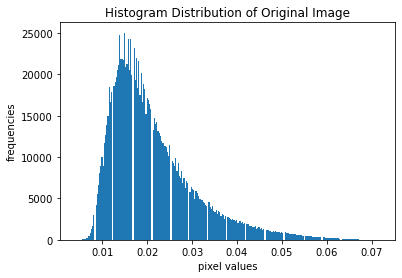

In [23]:
ax = plt.hist(img_blue.ravel(), bins = 256)

# Add title and axis names
plt.title('Histogram Distribution of Original Image')
plt.xlabel('pixel values')
plt.ylabel('frequencies')

plt.show()

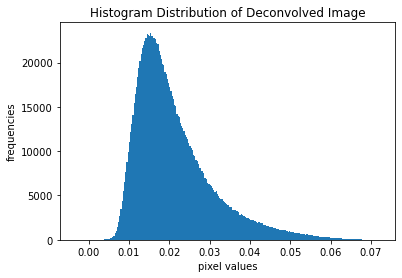

In [24]:
ax = plt.hist(deconvolved.ravel(), bins = 256)

# Add title and axis names
plt.title('Histogram Distribution of Deconvolved Image')
plt.xlabel('pixel values')
plt.ylabel('frequencies')

plt.show()